# The Laplacian operator

In this practical work, we study the Laplacian operator

$$ \nabla^2 C,$$
where $C$ is some scalar or vectorial field. 

The Laplacian operator is widely used in various fields such as physics, mathematics and engineering. Some equations involving this operator are:
1. **Poisson's Equation**:
      $$ \nabla^2 \phi = \rho $$
2. **Heat Equation**:
 $$ \frac{\partial T}{\partial t} = \alpha \nabla^2 T, $$

3. **Wave Equation**:
  $$ \frac{\partial^2 u}{\partial t^2} = c^2 \nabla^2 u, $$

4. **Schrödinger Equation**:
 $$ i\hbar \frac{\partial \psi}{\partial t} = -\frac{\hbar^2}{2m} \nabla^2 \psi + V\psi, $$

5. **Laplace's Equation**:
  $$ \nabla^2 \phi = 0 ,$$
 
6. **Helmoltz equation**:
$$ \nabla (D \nabla  A) - \lambda A = B.$$
   
The objective here is to build a solver for a reaction-diffusion equation. The work is divided as follows : (i) study of the diffusion equation in 1D, (ii) study of the 2D Laplace equation 2D using iterative methods and (iii) study of the 2D Poisson-Helmholtz equation, for which we will write a solver directly useful for solving the reaction-diffusion equation.

### Table of contents


1. [Diffusion Equation in 1D](#diffusion-equation-in-1d)
    1. [Analytical solution](#analytical-solution)
    2. [Finite Differences Scheme : explicit method](#explicit_method)    
    3. [Finite Differences Scheme : implicit method](#implicit_method)
    4. [Compare Both Approaches](#compare-both-approaches)
2. [Laplace Equation in 2D](#laplace-equation-in-2d)
    1. [Jacobi Approach](#jacobi-approach)    
    2. [Gauss-Seidel](#gauss-seidel)
3. [Poisson-Helmholtz Equation](#poisson-helmholtz-equation)
4. [Reaction-Diffusion Equation](#reaction-diffusion-equation)

## 1 Diffusion equation in 1D
 
The equation describing the 1D diffusion of a chemical contaminant of concentration $C$ and diffusion coefficient $D$ is written 
   $$ \frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} $$
    
The fluid domain is bounded by two absorbing walls located at $x=0$ and $x=L$, leading to the following boundary conditions : 

$$ C(0, t) = C(L, t)= 0 $$

Furthermore, we assume the following initial condition: 
$$ C(x, 0) = \sin(\frac{\pi x}{L})$$
 


### 1.1 Analytical solution

Using the Python library sympy verify that
$$ C = \exp\left(-\frac{D\pi^2 t}{L^2}\right)\sin\left(\frac{\pi x}{L}\right)$$
is a solution and represent it on a plot at different times. 


In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [2]:
pi,D,L= sp.symbols('pi,D,L')
x, t = sp.symbols('x t')
f_symb = sp.exp(-D*pi*pi/L/L*t) * sp.sin(pi/L*x)
print(f_symb)

exp(-D*pi**2*t/L**2)*sin(pi*x/L)


In [3]:
sp.diff(f_symb,t) - D * sp.diff(sp.diff(f_symb, x),x)

0

Text(0, 0.5, 'C(x, t)')

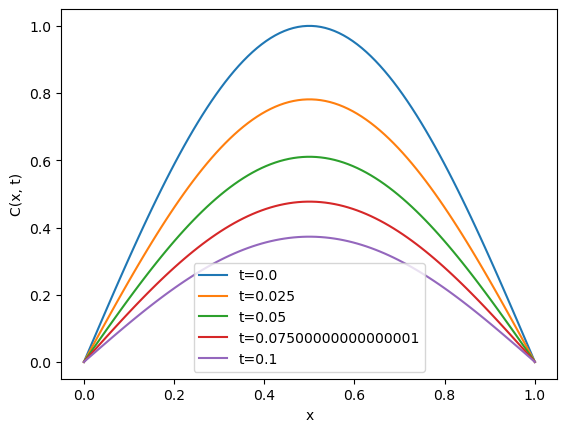

In [4]:
f = sp.lambdify((pi,D,L,x, t),f_symb,"numpy")
liste_x=np.linspace(0, 1, 100)
liste_t=np.linspace(0,0.1, 5)
for i in range(len(liste_t)):
    plt.plot(liste_x, f(np.pi, 1, 1, liste_x, liste_t[i] ), label='t='+str(liste_t[i]))
    
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x, t)')
    

### 1.2 Finite Difference scheme : explicit method

In the finite differences scheme, we discretize the spatial and temporal domains to approximate the derivatives in the heat equation.
The spatial domain is divided into $N_x$ grid points with spacing $dx$, and the time domain is divided into $N_t$ time steps with spacing $ dt $.



Using finite differences, the second-order spatial derivative can be approximated as:

$$ \frac{\partial^2 C}{\partial x^2} \approx \frac{C_{i-1} - 2C_i + C_{i+1}}{\Delta_x ^2} $$

The forward Euler method is used for the time derivative:
   
$$ \frac{\partial C}{\partial t} \approx \frac{C^{n+1} - C^n}{\Delta t} $$

Combining these approximations, the concentration at time $t_{n+1}$ is expressed as a function of the concentration field at time $t_n$ (explicit method) as:

$$ C_i^{n+1} = C_i^n + \frac{D  \Delta t}{\Delta_x ^2} \left( C_{i-1}^n - 2C_i^n + C_{i+1}^n  \right) $$
where $C_i^n$ is the concentration at spatial position $x_i$ and time $ t_n $
 

Q1: Write a function ```rhs_centered(C,dx, D)``` where $C$ is the concentration array at the current-time step, that returns the right-hand side of the 1D diffusion equation based on centered finite differences. Be  careful to impose the correct boundary conditions. 

In [5]:
def rhs_centered(C, dx, D):
   
    nx = C.shape[0]
    f = np.empty(nx)
    
    f[1:-1] = D/dx**2 * (C[:-2] - 2*C[1:-1] + C[2:]) 
    f[0] = 0.
    f[-1] = 0.
    
    return f

Q2: Write a function ```euler_step(C, f, dt, dx, D)``` that returns the concentration field $C(x, t+dt)$ given the concentration field $C(x, t)$, where $f(C, dx, D)$ is the right-hand side of the 1D diffusion equation based on centered finite differences. 

In [6]:
def euler_step(C, f, dt, dx, D):
   
    Cnp1 = C + dt * f(C, dx, D)
    return Cnp1

Q3: Write a function ```exact_solution(x,t,D, L)```returning the exact analytical solution. 

In [7]:
def exact_solution(x,t, D, L):
    
    f =  np.exp(-D*np.pi**2/L/L*t) * np.sin(np.pi*x/L)
   
    return f

Q4: Solve the 1D diffusion equation using the explicit finite difference scheme. Compare with the analytical solution. 

In [8]:
# Physical parameters
D = 1               # Diffusion coefficient
L = 1.                 # Size of computational domain

# Grid parameters
nx = 100                        # number of grid points 
dx = L / (nx-1)                # grid spacing
x = np.linspace(0., L, nx)     # coordinates of grid points

# Time parameters
ti = 0.                         # initial time
tf = 5.                         # final time

dt = 0.00001

nt = int((tf-ti) / dt)          # number of time steps

# Initial condition
C0 = np.sin(np.pi*x/L)          # initial condition

C = np.empty((nt+1, nx))
C[0] = C0

for i in range(nt):
    C[i+1] = euler_step(C[i], rhs_centered, dt, dx, D)

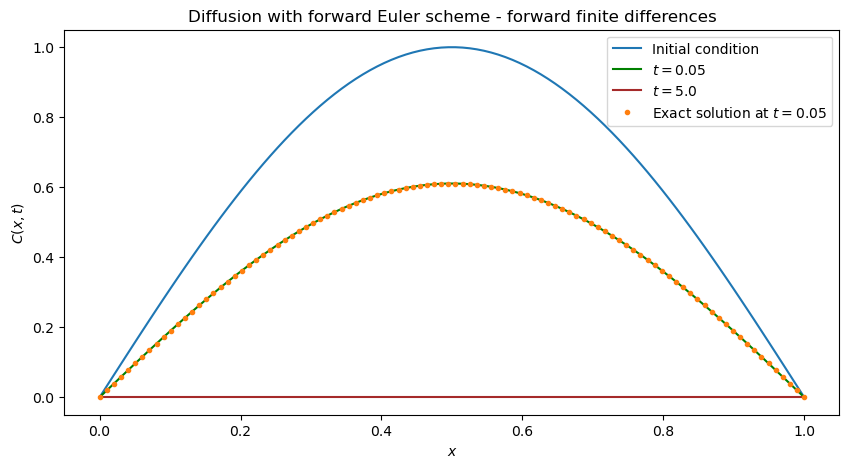

In [9]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, C[0], label='Initial condition')
ax.plot(x, C[int(0.05/dt)], color='green', label='$t=0.05$')
ax.plot(x, C[-1], color='brown', label=f'$t={tf}$')
ax.plot(x, exact_solution(x, 0.05, D, L), '.', label='Exact solution at $t=0.05$')


ax.set_xlabel('$x$')
ax.set_ylabel('$C(x, t)$')
ax.set_title('Diffusion with forward Euler scheme'
             ' - forward finite differences')
ax.legend();


### 1.3 Finite difference scheme : implicit method

This time, we use a backward Euler method for the time derivative. Combining with the centered finite difference approximation of the right-hand side of the 1D diffusion equation: 
 
$$ C_i^{n+1} - \frac{D \Delta t}{\Delta x^2} \left( C_{i-1}^{n+1} - 2C_i^{n+1} + C_{i+1}^{n+1} \right) = C_i^n $$

This can be rearranged into a system of linear equations:
$$ \left( 1 + 2\frac{D \Delta t}{\Delta x^2} \right) C_i^{n+1} - \frac{D \Delta t}{\Delta x^2} \left( C_{i-1}^{n+1} + C_{i+1}^{n+1} \right) = C_i^n $$

It can be put into the matrix form $A x = b$, where $x=C^{n+1}$ and $b=C^n$.

Q1: Write a function ```matrix_implicit(D, dt, dx)```than returns the sparse matrix A. 

In [10]:
def matrix_implicit(D, dt, dx):
    
    r = D * dt / dx**2
    d1 = -r *np.ones(nx)
    d0 = (1 + 2 * r)* np.ones(nx)

    A = sps.spdiags([d1,d0,d1], [-1,0,1],nx,nx,format='csc')
    A[0,0] = A[-1,-1]= 1
    A[0,1] = A[-1,-2]= 0
    
    return A


Q2: Solve the 1D diffusion equation using the implicit finite difference scheme (use ```spsolve```) and compare with the analytical solution. 

In [11]:
# Physical parameters
D = 1               # Diffusion coefficient
L = 1.                 # Size of computational domain

# Grid parameters
nx = 100                        # number of grid points 
dx = L / (nx-1)                # grid spacing
x = np.linspace(0., L, nx)     # coordinates of grid points

# Time parameters
ti = 0.                         # initial time
tf = 5.                         # final time

dt = 0.00001

nt = int((tf-ti) / dt)          # number of time steps

# Initial condition
C0 = np.sin(np.pi*x/L)          # initial condition

A= matrix_implicit(D, dt, dx)

C = np.empty((nt+1, nx))
C[0] = C0


for i in range(nt):
    C[i+1] = spsolve(A,C[i])

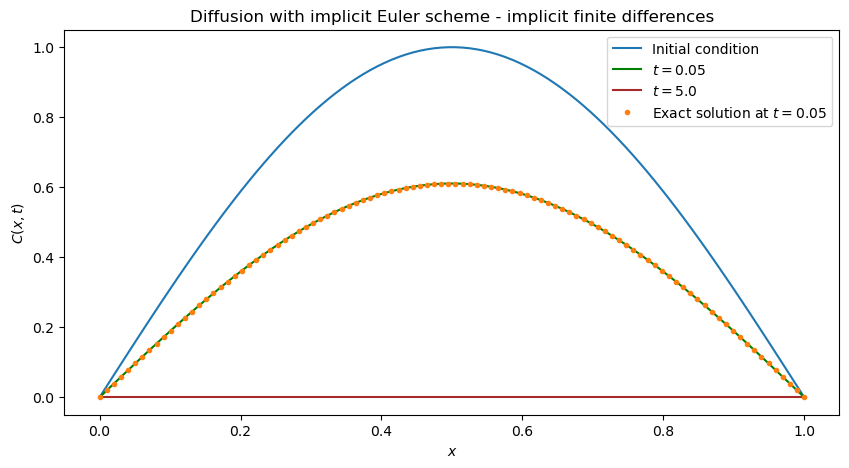

In [12]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, C[0], label='Initial condition')
ax.plot(x, C[int(0.05/dt)], color='green', label='$t=0.05$')
ax.plot(x, C[-1], color='brown', label=f'$t={tf}$')
ax.plot(x, exact_solution(x, 0.05, D, L), '.', label='Exact solution at $t=0.05$')


ax.set_xlabel('$x$')
ax.set_ylabel('$C(x, t)$')
ax.set_title('Diffusion with implicit Euler scheme'
             ' - implicit finite differences')
ax.legend();

### 1.4 Compare both approaches

Compare the explicit and implicit methods and perform a stability analysis (by varying the time step $dt$).  

In [13]:
# Physical parameters (recall)
D = 1                    # Diffusion ansfer coefficient
L = 1.                        # Size of computational domain
ti = 0.0                       # Initial time
tf = 5.0                       # Final time

# Grid parameters
nx = 100                    # number of grid points
dx = L/ (nx-1)               # grid spacing
x = np.linspace(0., L, nx)    # coordinates of grid points

dt = 0.001 
nt = int((tf-ti) / dt)              # number of time steps

A=matrix_implicit(D, dt, dx)

# Solution parameters
C0 = np.sin(np.pi*x)              # initial condition

In [14]:
Cimp = np.empty((nt+1, nx))
Cimp[0] = C0

for i in range(nt):
    Cimp[i+1] = spsolve(A,Cimp[i])

In [15]:
Cexp = np.empty((nt+1, nx))
Cexp[0] = C0

for i in range(nt):
    Cexp[i+1] = euler_step(Cexp[i], rhs_centered, dt, dx, D)

/var/folders/1s/t4vc7_ws4k3cr8v363bdg8280000gn/T/ipykernel_70373/455268520.py:6: RuntimeWarning: overflow encountered in multiply
  f[1:-1] = D/dx**2 * (C[:-2] - 2*C[1:-1] + C[2:])
/var/folders/1s/t4vc7_ws4k3cr8v363bdg8280000gn/T/ipykernel_70373/1243944334.py:3: RuntimeWarning: invalid value encountered in add
  Cnp1 = C + dt * f(C, dx, D)
/var/folders/1s/t4vc7_ws4k3cr8v363bdg8280000gn/T/ipykernel_70373/455268520.py:6: RuntimeWarning: invalid value encountered in add
  f[1:-1] = D/dx**2 * (C[:-2] - 2*C[1:-1] + C[2:])


Text(0.5, 1.0, 'Comparison of Implicit and Explicit schemes')

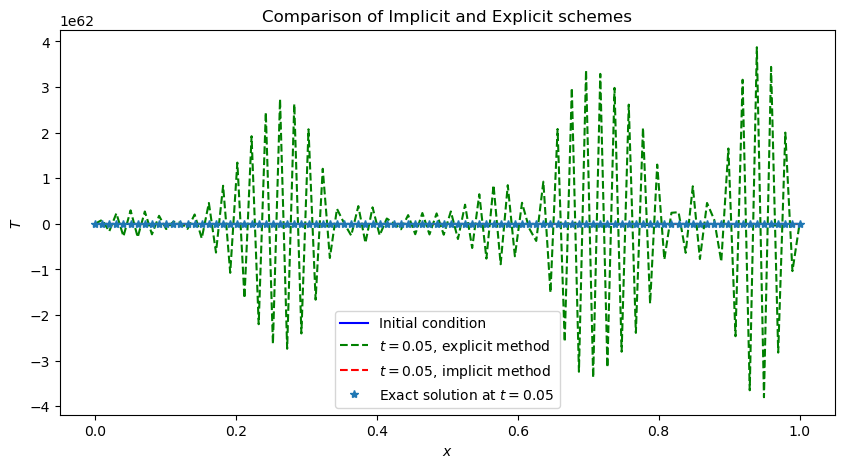

In [16]:
# plot the solution at several times
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, C0, color='blue', label='Initial condition')
ax.plot(x, Cexp[int(0.05/dt)], '--', color='green', label='$t=0.05$, explicit method')
ax.plot(x, Cimp[int(0.05/dt)], '--', color='red', label='$t=0.05$, implicit method')

#ax.plot(x, Cexp[-1], color='brown', label=f'$t={tf}$')
ax.plot(x, exact_solution(x, 0.05, D, L), '*', label='Exact solution at $t=0.05$')

plt.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$T$')
ax.set_title('Comparison of Implicit and Explicit schemes')

## 2 Laplace equation in 2D

Inverting matrices for solving the diffusion equation in 2D can be complicated, we propose then to study some iterative approaches.

We study first the 2D Laplace equation 
$$ \nabla^2 C = \frac{\partial^2 C}{\partial x^2} + \frac{\partial^2 C}{\partial y^2}=0 $$

and we consider the fluid domain $[0, 1] \times [0, 1]$. The boundary conditions are: 
$$ C(x=0, y)=y, \quad C(x=1, y)=y-1, \quad C(x, y=0)=-y, \quad C(x, y=1)=1-y$$. 

The 5-point Laplacian is a finite difference approximation of the Laplace operator in two dimensions. It is commonly used in numerical methods to solve partial differential equations such as the Poisson equation. 


Using the 5-point stencil, the discrete approximation of the Laplacian at a grid point $(i, j)$ is

$$ \nabla^2 C_{i,j} \approx \frac{C_{i+1,j} - 2C_{i,j} + C_{i-1,j}}{\Delta x^2} + \frac{C_{i,j+1} - 2C_{i,j} + C_{i,j-1}}{\Delta y^2} $$
   
For a uniform grid where $\Delta x = \Delta y = h$, this simplifies to:
  
$$ \nabla^2 C_{i,j} \approx \frac{C_{i+1,j} + C_{i-1,j} + C_{i,j+1} + C_{i,j-1} - 4C_{i,j}}{h^2} $$

This formula is used to approximate the second derivatives in the Laplace equation, providing a way to discretize the equation for numerical solutions.
The iterative process is
$$ C_{i,j} = \frac{1}{4} ( C_{i+1,j} + C_{i-1,j} + C_{i,j+1} + C_{i,j-1} ) $$
 

### 2.1 Jacobi approach

Q1: First define a function ```jacobi(grid)``` that returns a new concentration field from an initial field ```grid```using the iterative process: 
$$ C_{i,j} = \frac{1}{4} ( C_{i+1,j} + C_{i-1,j} + C_{i,j+1} + C_{i,j-1} ) $$
Don't forget to copy the boundary conditions of the initial field. 


In [17]:
def jacobi(grid):
    newgrid = np.zeros(shape=grid.shape,dtype=grid.dtype)

    # apply evolution operator
    newgrid[1:-1,1:-1] = 0.25 * (grid[1:-1,:-2] + grid[1:-1,2:] +
                                 grid[:-2,1:-1] + grid[2:,1:-1])

    # copy boundary conditions
    newgrid[0,:]  = grid[0,:]
    newgrid[-1,:] = grid[-1,:]
    newgrid[:,0]  = grid[:,0]
    newgrid[:,-1] = grid[:,-1]
    
    return newgrid

Q2: Define a function ```boundary(grid)```that imposes the required boundary conditions on a given ```grid```. 

In [18]:
def boundary(grid):
    x = np.linspace(0,1,len(grid))
    
    grid[0,:]  = x
    grid[:,-1] = 1-x
    grid[-1,:] = x-1
    grid[:,0]  =-x

    


Q3: Define a function ```initgrid(gridsize)``` that randomly initializes a grid of size ```gridsize```x ```gridsize```. You may use the function ```np.random.randn```. Don't forget to impose the required boundary conditions. 


In [19]:
def initgrid(gridsize):
    x = np.random.randn(gridsize,gridsize)
    boundary(x)
    
    return x

Q4: Solve the 2D Laplace equation on a grid of size $25\times 25$ and represent the solution at different iteration stops.  To represent the solution, you may run first the following cell and use the function ```showsol(grid)```. 

In [20]:
import matplotlib as ml
def showsol(sol):
    plt.imshow(sol.T,cmap=ml.cm.Blues,interpolation='none',origin='lower')
    cbar=plt.colorbar()
    cbar.set_label('C(x,y)')

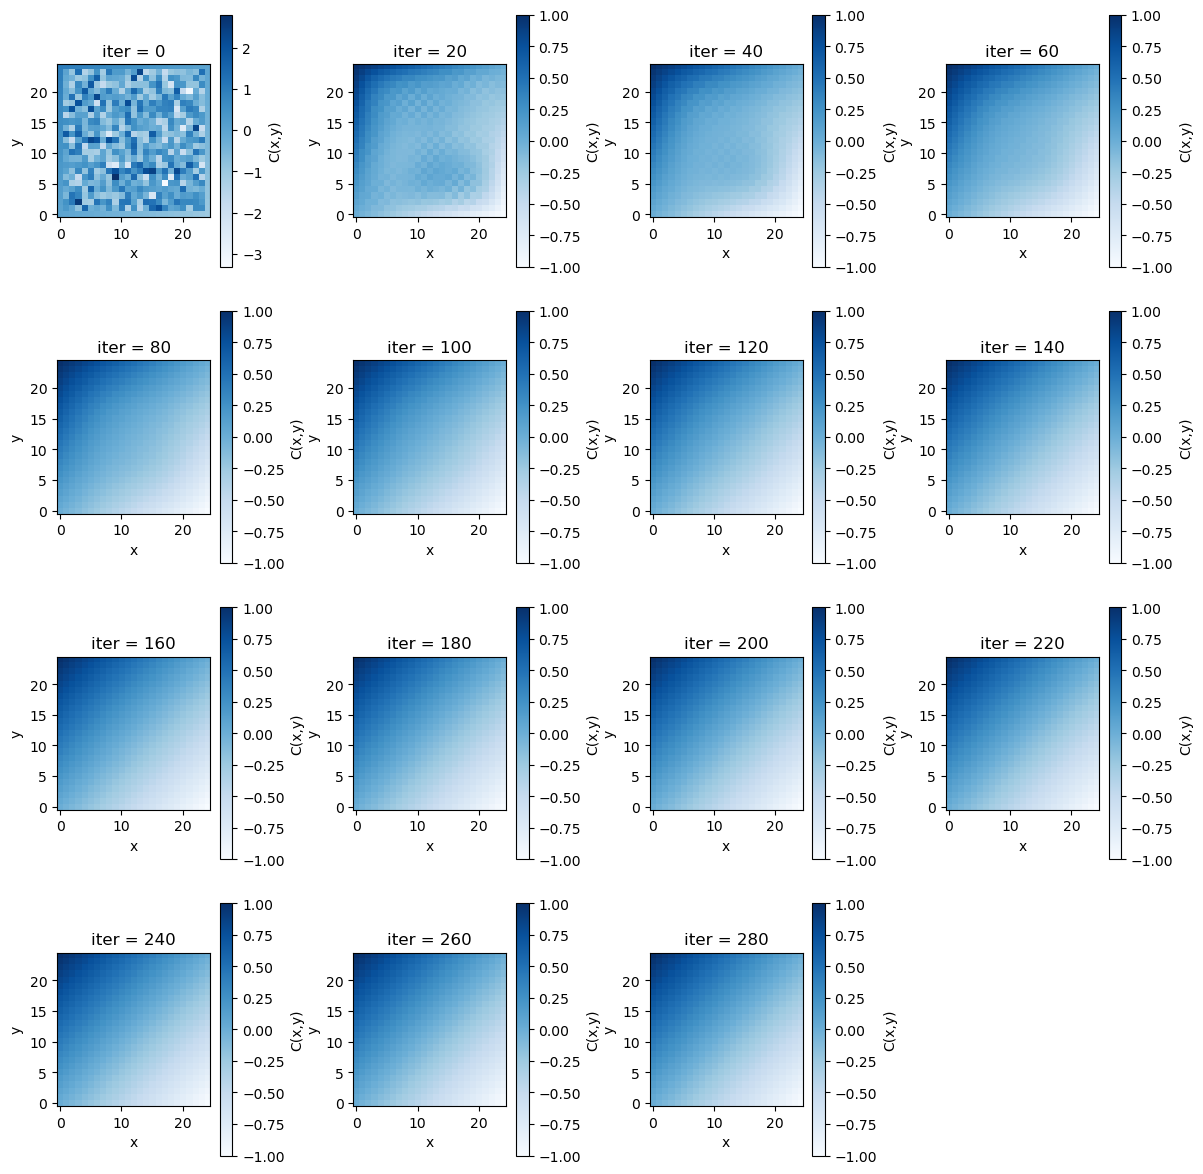

In [21]:
x = initgrid(25)

plt.figure(figsize=(12,12))

for i in range(300):    
    if i % 20 == 0:
        plt.subplot(4,4,int(i/20+1))
        showsol(x)
        plt.title('iter = %s' % i)
        plt.xlabel('x')
        plt.ylabel('y')
        ml.colorbar
        
    x = jacobi(x)

plt.tight_layout()

Q5: Perform a convergence analysis by calculating the error at each iteration, computed as the difference between the norm of the final solution (obtained after many iterations) and the one of the current grid.  

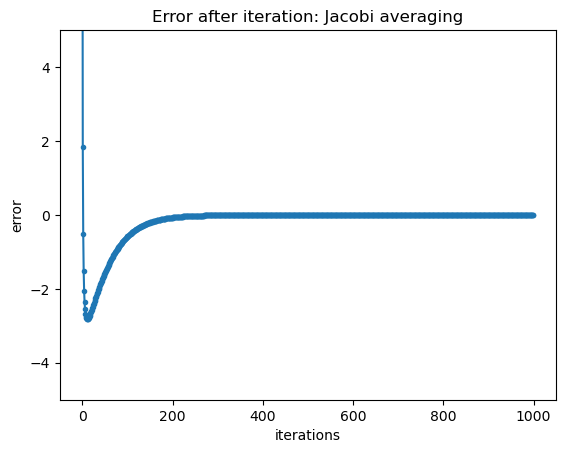

In [22]:
x = initgrid(25)

err_jacobi = []

for i in range(1000):    
    err_jacobi.append((i,np.linalg.norm(x)))
            
    x = jacobi(x)

err_jacobi = np.array(err_jacobi)
    
#plt.semilogy(err_jacobi[:,0],err_jacobi[:,1]-err_jacobi[-1,1])
plt.plot(err_jacobi[:,0],err_jacobi[:,1]-err_jacobi[-1,1],'.-')
plt.ylim(-5,5)
plt.xlabel('iterations')
plt.ylabel('error')
plt.title('Error after iteration: Jacobi averaging');

### 2.2 Gauss-Seidel approach 

We now turn to the Gauss-Seidel method. Starting with an initial guess for $C$ it updates the solution at each grid point using the formula above. The key idea of Gauss-Seidel is that each time a grid point $C(i, j)$ is updated, the new value is immediately used in subsequent updates within the same iteration. This makes the method faster to converge compared to the Jacobi method, which updates all points after a full sweep of the grid.

Q1: Define a function ```gauss-seidel(grid)```that returns the grid updated with a Gauss-Seidel method. 

In [23]:
def gauss_seidel(grid):
    newgrid = grid
    
    for i in range(1,newgrid.shape[0]-1):
        for j in range(1,newgrid.shape[1]-1):
            newgrid[i,j] = 0.25 * (newgrid[i,j+1] + newgrid[i,j-1] +
                                   newgrid[i+1,j] + newgrid[i-1,j])
    
    return newgrid

Q2:  Perform a convergence analysis and compare with the Jacobi method. 

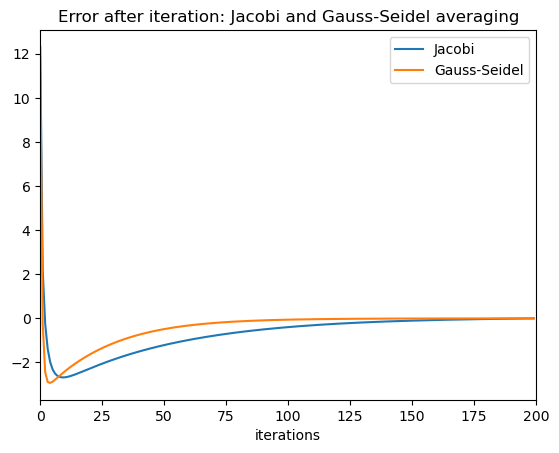

In [24]:
x = initgrid(25)

err_gs = []
err_jacobi = []

for i in range(200):    
    err_jacobi.append((i,np.linalg.norm(x)))
    x = jacobi(x)

err_jacobi = np.array(err_jacobi)
    
x = initgrid(25)
for i in range(200):    
    err_gs.append((i,np.linalg.norm(x)))
    x = gauss_seidel(x)

err_gs = np.array(err_gs)
    
plt.plot(err_jacobi[:,0],err_jacobi[:,1]-err_jacobi[-1,1])
plt.plot(err_gs[:,0],err_gs[:,1]-err_gs[-1,1])
plt.xlim(0,200)
plt.title('Error after iteration: Jacobi and Gauss-Seidel averaging')
plt.xlabel('iterations')
plt.legend(['Jacobi','Gauss-Seidel']);

## 3 The Poisson-Helmholtz equation 

The Poisson-Helmholtz equation is a partial differential equation that combines aspects of both the Poisson and Helmholtz equations. It is commonly used in various fields such as physics and engineering to describe phenomena like wave propagation, electrostatics, and heat conduction.

The general form of the Poisson-Helmholtz equation is:
$$ \nabla (D \nabla  A) - \lambda A = B$$
where $A$ is a scalar field, $D$ is the diffusion coefficient, $\lambda$ is a constant and $B$ is the source term.  

In the context of numerical methods, solving the Poisson-Helmholtz equation typically involves discretizing the equation using finite difference or finite element methods and then solving the resulting system of linear equations.
  
We aim at solving the Poisson-Helmoltz equation in 2D. To do so, we will assume a constant diffusion coefficient $D$. Under this assumption, the equation can be discretized as follow: 

$$ D  (A_{i+1,j} + A_{i-1,j} + A_{i,j+1} + A_{i,j-1} - 4 A_{i,j}) - \lambda  A_{i,j} =  B_{i,j}$$

The iterative algorithm is then:
 $$ A_{i,j} = {- B_{i,j} + D  (A_{i+1,j} + A_{i-1,j} + A_{i,j+1} + A_{i,j-1}) \over 4 D + \lambda}$$
 
  

Q1: Define a function ```poisson_helmoltz_jacobi(u,D,l,b)```that, given a grid $u$, returns the updated grid by implementing the above iterative algorithm, with the Jacobi method. 

In [25]:
def poisson_helmoltz_jacobi(u,D,l,b):
    newa = np.zeros(shape=u.shape,dtype=u.dtype)

     # copy boundary conditions
    newa[0,:]  = u[0,:]
    newa[-1,:] = u[-1,:]
    newa[:,0]  = u[:,0]
    newa[:,-1] = u[:,-1]

    # apply evolution operator
    newa[1:-1,1:-1] = (-b[1:-1,1:-1]+D*(u[1:-1,:-2] + u[1:-1,2:] +
                                 u[:-2,1:-1] + u[2:,1:-1]))/(4*D+l)

  
    
    return newa

Q2: Solve the equation for $\lambda=0$ and $B=0$ and the same initial and boundary conditions as used to solve the 2D Laplace equation. Make sure you obtain the same results than previously, by plotting the solution after various iteration numbers and comparing with the plots obtained solving the Laplace equation. 

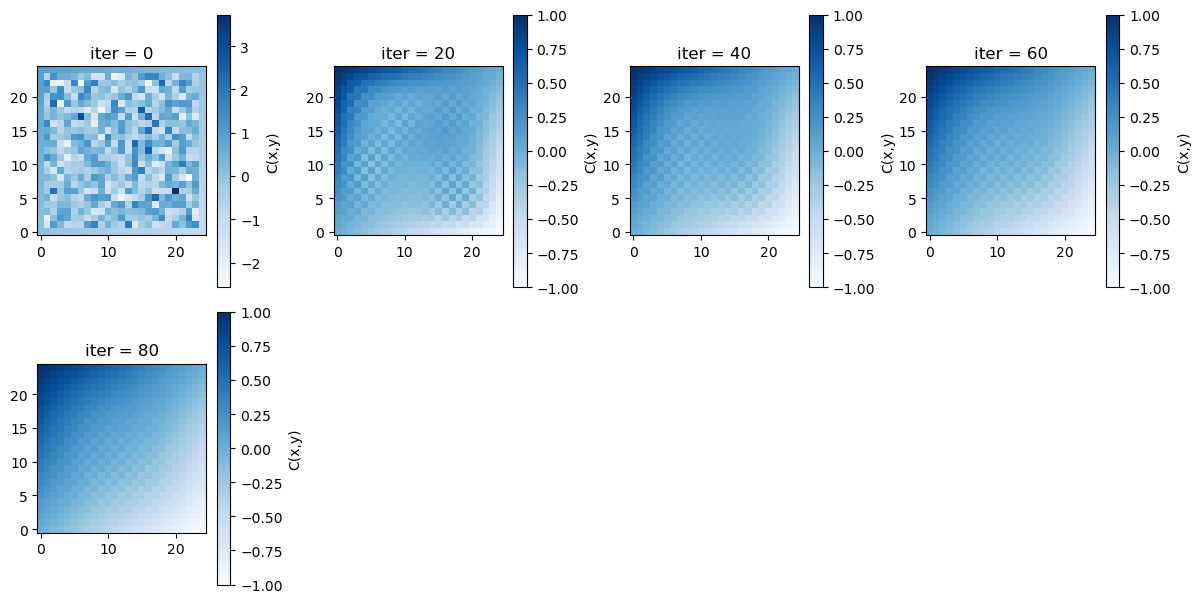

In [26]:
x = initgrid(25)

B = np.zeros(shape=(25,25),dtype='d')

plt.figure(figsize=(12,12))

for i in range(100):    
    if i % 20 == 0:
        plt.subplot(4,4,int(i/20+1))
        showsol(x)
        plt.title('iter = %s' % i)
        
    x = poisson_helmoltz_jacobi(x,D,0,B)

plt.tight_layout()

Q3: Define a function ```poisson_helmoltz_gs(u,D,l,b)```that, given a grid $u$, returns the updated grid by implementing the above iterative algorithm, with the Gauss-Seidel method. 

In [27]:
def poisson_helmoltz_gs(u,D,l,b):
    newgrid = u
    
    for i in range(1,newgrid.shape[0]-1):
        for j in range(1,newgrid.shape[1]-1):
            newgrid[i,j] = (-b[i, j]+ D*(newgrid[i,j+1] + newgrid[i,j-1] +
                                   newgrid[i+1,j] + newgrid[i-1,j]))/(4*D+l)
    
    return newgrid

  

Q4: Perform a convergence analysis and compare both methods in the case of the 2D Poisson-Helmholtz equation. You may use $\lambda=0.1$ and $B$ corresponding to a point source located at coordinates $(0.5, 0.5)$. 

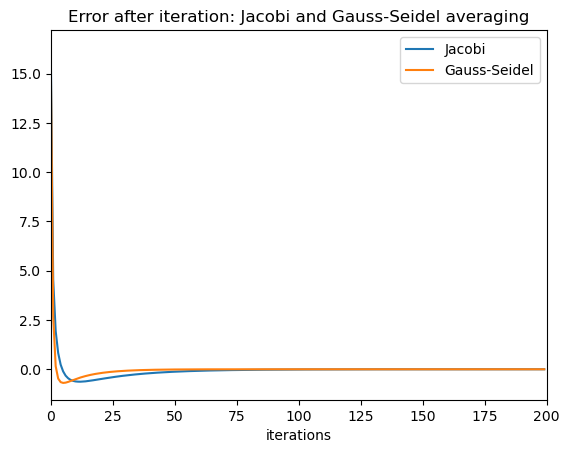

In [28]:
D=1
l=0.1
n=25

b=np.zeros((n, n))
b[int(n/2), int(n/2)]=1



err_gs = []
err_jacobi = []

x = initgrid(n)
for i in range(200):    
    err_jacobi.append((i,np.linalg.norm(x)))
    x = poisson_helmoltz_jacobi(x, D, l, b)

err_jacobi = np.array(err_jacobi)
    
x = initgrid(n)
for i in range(200):    
    err_gs.append((i,np.linalg.norm(x)))
    x = poisson_helmoltz_gs(x, D, l, b)

err_gs = np.array(err_gs)
    
plt.plot(err_jacobi[:,0],err_jacobi[:,1]-err_jacobi[-1,1])
plt.plot(err_gs[:,0],err_gs[:,1]-err_gs[-1,1])
plt.xlim(0,200)
plt.title('Error after iteration: Jacobi and Gauss-Seidel averaging')
plt.xlabel('iterations')
plt.legend(['Jacobi','Gauss-Seidel']);

## 4 Reaction-Diffusion equation

The general reaction-diffusion equation reads:
$$ \frac{\partial C}{\partial t} = D \nabla^2 C + \beta C + R, $$
where $R$ is a source term and $\beta$ is a growth rate of the substance of concentration $C$. 

This equation can be discretized into :
$$ \frac{C^{n+1} - C^n}{\Delta t} =  D \nabla^2 C^{n+1} + \beta C^{n+1} + R$$ 

We can write it in a Poisson-Helmoltz form: 
$$ D \nabla^2 C^{n+1} + (\beta  - \frac{1}{dt}) C^{n+1} = - \frac{1}{dt} C^n - R $$
Thus, noting $\lambda = \beta  - \frac{1}{dt}$ and $B =  -\frac{1}{dt} C^n - R $, the discrtized reaction diffusion equation writes: 
 
  $$ D \nabla^2 C^{n+1} + \lambda C^{n+1} = B$$
  
Thus, you have now an algorithm to solve reaction-diffusion problems in 2D ! 
 